# A Basic Tutorial on Adjoint-Based *A Posteriori* Error Analysis

## Setting the stage

This is a basic tutorial.
For more background information and advanced examples, see http://www.stat.colostate.edu/~estep/assets/adjointcourse_final2.pdf.

### A forward (finite dimensional linear) problem
Suppose $A\in\mathbb{R}^{n\times n}$, $b\in\mathbb{R}^n$, and the goal is to determine $x\in\mathbb{R}^n$ such that 
$$
\large Ax = b.
$$
Here, $x$ is the vector of states, $A$ describes the relations between the states, and $b$ is the data.

***In practice, we use numerical algorithms to generate a numerical solution $X\approx x$.***

### Quantifying error
Having computed an approximate $X$, the ***uncomputable*** error is 
$$
\large e := x-X.
$$
However, the residual 
$$
\large R := b-AX
$$
is ***computable***, but given some norm on $\mathbb{R}^n$, $R$ may be *small* even when $e$ is *large*.

For example, 
$$
A=\begin{pmatrix} 1 & 1 \\ 1 & 1+\delta \end{pmatrix}, \quad b=\begin{pmatrix} 1 \\ 1 \end{pmatrix}.
$$
with exact solution $x$ and approximate solutions $\hat{x}$ and $\tilde{x}$
$$
x=\begin{pmatrix} 1 \\ 0 \end{pmatrix}, \quad \hat{x}=\begin{pmatrix} 11 \\ -10 \end{pmatrix} \quad \tilde{x}=\begin{pmatrix} 1+\delta \\ 0 \end{pmatrix}.
$$

$R(\hat{x})=-10\delta$, $R(\tilde{x})=\delta$, so the *residual is $\mathcal{O}(\delta)$ for both cases* but the **error** is $\mathcal{O}(1)$ for $\hat{x}$.  

## Setting up a numerical environment in Python

We use ``numpy`` so that we can work with arrays (matrices and vectors), and ``scipy`` for performing certain scientific computations in our example below. 
The library ``matplotlib`` is used for creating some visualizations.

For more information on these packages, see http://scipy.org/.

In [1]:
import numpy as np 
import scipy.sparse as sparse
import scipy.sparse.linalg as splinalg
import scipy.linalg as linalg
import matplotlib.pyplot as plt

#The next line enables the display of graphical output within Jupyter Notebooks and is NOT needed outside of Notebooks"
%matplotlib inline

/Users/Undertrick/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


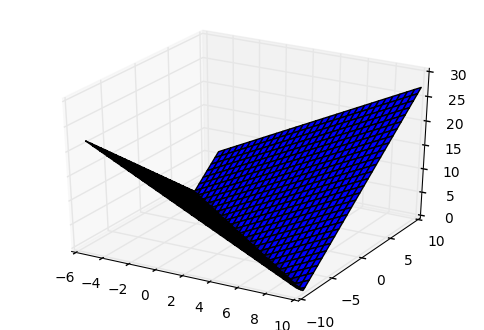

In [2]:
#This line is for 3D plotting in matplotlib
from mpl_toolkits.mplot3d import Axes3D

def plot_residual(A,b,x,y):
    
    res_nrm=np.zeros(np.shape(xp))
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            res=b-np.dot(A,np.array([[x[i,j]],[y[i,j]]]))
            res_nrm[i,j]=np.linalg.norm(res)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xp,yp,res_nrm)

    
delta=1E-2
A=np.matrix([[1,1],[1,1+delta]])
b=np.ones([2,1])
x=np.linspace(-5,10,300)
y=np.linspace(-10,10,300)
xp,yp=np.meshgrid(x,y)
plot_residual(A,b,xp,yp)

#btilda=np.array([[1],[0]])
#plot_residual(A,btilda,xp,yp)

### Quantities of interest
We are often motivated to solve problems in order to compute a relatively small number of scalar ***Quantities of Interest (QoI)*** from the solution that correspond to important physical quantities. 
Many times, these QoI can be written as linear functionals of the solution. 
In this case, we do not care so much for what the general error is in the numerical solution compared to how this error impacts the computed QoI that uses the numerical solution.
For the sake of simplicity, assume we care about a single QoI that we denote by $Q$.

In our $2\times 2$ example, and example QoI might be the mean of the solution vector $x$, i.e. $\frac{1}{n}\sum_i x_i$.

#### The Riesz Representation Theorem
If $Q$ is linear functional of $x$, then there exists $\psi\in\mathbb{R}^n$ such that
$$
   \large Q(x) = \left< x, \psi \right>.
$$
Here, $\left<\cdot,\cdot\right>$ is the usual inner product on $\mathbb{R}^n$. 

In our $2x2$ example, with $Q(x)$ equal to the mean of $x$, it is not hard to see that the Riesz representor $\psi$ is 
$$
\frac{1}{N} \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix}
$$

With the Riesz Representation Theorem in hand, and exploiting the linearity of the inner product, we now see that the error we care about in the QoI can be written as
\begin{eqnarray*}
    \large e_Q &:=& \large Q(x)-Q(X) \\ \\
               &=&  \large \left<x,\psi\right> - \left<X,\psi\right> \\ \\
               &=&  \large  \left<x-X,\psi\right> \\ \\
               &=&  \large \underbrace{\left<e,\psi\right>}_{\text{uncomputable}}.
\end{eqnarray*}

For our toy ill-conditioned problem, note that $\|{e}\|=x-\hat{x}$ was large, but if the QoI was the mean, $Q(x)=Q(\hat{x})=.5$, so $Q(e)=0$.

### The adjoint problem
We define the adjoint problem as
$$
\large A^\top \phi = \psi.
$$
***Note that the data of the adjoint problem is determined by the QoI, and the structure of the adjoint operator is determined by the forward problem.***
Suppose we solve the adjoint problem ***exactly*** to obtian $\phi$ (we return to this assumption below). 

### A computable a posteriori error (estimate)
We now exploit properties of the inner product and use the adjoint problem.
\begin{eqnarray*}
    \large \underbrace{\left<e,\psi\right>}_{\text{uncomputable}} &=&  \large \left<e,A^\top\phi\right>  \\ \\
               &=&  \large  \left<Ae,\phi\right> \\ \\
               &=&  \large \underbrace{\left<R,\phi\right>}_{\text{computable}}.
\end{eqnarray*}
We have derived a computable form of the a posteriori error that takes the form of the residual weighted by the adjoint solution.

In general, we do not have the exact solution to the adjoint problem, $\phi$, but rather a numerical estimate, $\Phi\approx\phi$.
Replacing $\phi$ with $\Phi$ results in a computable a posteroiri ***estimate*** given by
$$
    \large e_Q \approx \left<R, \Phi\right>. 
$$


### Contrast with *a priori* error estimation

For our toy problem, 
$$
\|e \| \leq \|\text{Residual}\|\times{\kappa_A}\|x \|
$$
where $\kappa_A$ is the condition number.

We have 
$$
Q(e) = <\mathcal{R}(X),\Phi> + <\mathcal{R}(X),\phi-\Phi>
$$
Taking absolute values, we have 
$$
|Q(e)| \leq |<\mathcal{R}(X),\Phi>| + |<\mathcal{R}(X), \phi-\Phi>| \leq |<\mathcal{R}(X),\Phi>| + \|\mathcal{R}(X)\| \| \mathcal{R}(\Phi) \|\kappa(A^\top) \| \| \phi \|
$$

If both residuals are computed with the same accuracy $\epsilon$, the uncomputable error is $\mathcal{O}(\kappa(\Phi)\epsilon^2)$.

If we drop the second term and apply Cauchy-Schwarz, we obtain
$$
|Q(e)| \leq  \| \mathcal{R}(X)\| \| \Phi \|
$$
So we can think of $\| \Phi \|$ as a *weak condition number* corresponding to a particular $QoI$.

What if we didn't solve the adjoint problem?  Our best **a posteriori** knowledge would be:

$$
|<e,\psi>| \leq \kappa(A) \mathcal{R}(X) \|x\| \| \psi \|
$$ 
where we would estimate the condition number of $A$ and use $X$ as a surrogate for the true solution $x$.

Let's recap with our toy problem.  I solve via some algorithm, and get a small residual, high error answer $$\hat{x}=X=\begin{pmatrix} 11 \\ -10 \end{pmatrix}, \quad 
A=\begin{pmatrix} 1 & 1 \\ 1 & 1+\delta \end{pmatrix}, \quad b=\begin{pmatrix} 1 \\ 1 \end{pmatrix}, \quad R(X)=\begin{pmatrix} 0 \\ 10\delta \end{pmatrix}
$$
We solve the adjoint problem (for the mean QoI) $A^\top \Phi = \psi$,
$$
A^\top=A, \quad \psi=\frac{1}{2}\begin{pmatrix} 1 \\ 1 \end{pmatrix} = \frac{1}{2}b
$$
and get another high error answer for $\Phi=(11+\epsilon_1,-10+\epsilon_2)^\top$.  

Our error estimate would be $10\delta(-10+\epsilon_2)$, still small.

But change the QoI to the value of the $x$-component($\psi=[1 \quad  0]^\top$, but now 
$$\phi \approx \frac{1}{\delta} \begin{pmatrix} 1+ \delta \\ -1 \end{pmatrix}
$$
and we would obtain an error estimate of roughly 10. 

Our non-adjoint based bound would be

In [3]:
kappa=np.linalg.cond(A)
x=np.array([11,-10])
print 'condition number of A =',kappa
psi=.5*np.array([1,1])
err_est=10*delta*kappa*np.linalg.norm(x)*np.linalg.norm(psi)

print 'Crude a posteriori estimate =', err_est

condition number of A = 402.007512484
Crude a posteriori estimate = 422.586197484


## Towards the continuous (forward) problem

Consider the two-point boundary value problem
$$
    \large u'' = e^{\alpha x}, \ x\in(0,1), \ u(0)=u(1)=0.
$$
Here, $\alpha$ is some parameter. 
We will play around with different values below. 

We use a three-point centered finite difference scheme on a uniform mesh of $(0,1)$ with grid spacing $h=0.05$ to discretize this problem into a matrix-vector problem of the form
$$
    \large Au_h = b, 
$$
where $u_h$ is a vector of nodal values that approximate the solution $u$ at the grid points of the mesh.

***We are interested in $u_h$ not $u$ here. We simply use the differential equation to motivate the matrix-vector problem.***

In [4]:
# Setup computational grid
#alpha = 10.0 # Try 0.0 and 10.0
alpha = 0.0
h = .05
xval = np.arange(h, 1.0, h)
num_pts = len(xval)

print xval

[ 0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6
  0.65  0.7   0.75  0.8   0.85  0.9   0.95]


In [5]:
# Discretize BVP 

# Step 1: Define data b
# Uniform grid so can move h to right hand side
b = h**2*np.exp(alpha*xval)

# Step 2: Define matrix A
# We use the spdiags command to map -1 2 1 to the tridiagonal matrix A
temp = np.hstack((-np.ones((num_pts,1)), 2.0*np.ones((num_pts,1)), -np.ones((num_pts,1)))).transpose()
A = sparse.spdiags(temp, [-1,0,1], num_pts, num_pts, format = "csr")

## Solving the forward problem

We approximate the solution $U_h\approx u_h$ by using seven iterations of the conjugate gradient method with no preconditioner (see https://en.wikipedia.org/wiki/Conjugate_gradient_method for more details on this method). 

We also obtain the "exact" $u_h$ by performing a direct solve.

In [6]:
# Compute the approximate solution with CG method
(U_h,_) = splinalg.cg(A, b,tol=1.0e-20, maxiter=7)

# Compute the "exact" solution
u_h = splinalg.spsolve(A,b)

## Define the QoI

We assume we are interested in two QoI that are motivated by the continuous BVP:
   * $Q_1(u_h) = u_{h,9}$ (the 10*th* component of $u_h$ approximates $u(0.5)$)
   
   * $Q_2(u_h) = 0.2\sum_{j=11}^{14} u_{h,j}$ (this weighted sum approximates the average value of $u$ over $[0.6,0.8]$)

We see that these QoI correspond to inner products of $u_h$ with $\psi_1$ and $\psi_2$ where
   * $\psi_{1,j} = 1$ if $j=9$ otherwise $\psi_{1,j}=0$
   
   * $\psi_{2,j}=0.2$ if $j=11,\ldots,14$ otherwise $\psi_{2,j}=0$.

In [7]:
# Define the adjoint data vectors
psi_1 = np.zeros((num_pts,1))
psi_1[9] = 1

psi_2 = np.zeros((num_pts,1))
psi_2[11:15] = 0.2

## Setup and solve the adjoint problems

We need to solve
$$
\large A^\top \phi_1 = \psi_1, \ \text{ and } \ A^\top\phi_2 = \psi_2.
$$

We solve the adjoint problems "exactly" using a direct solver.

In [8]:
phi_1 = splinalg.spsolve(A,psi_1)
# Optional inexact solve for QoI 1
#(Phi_1,_) = splinalg.cg(A, psi_1,tol=1.0e-20, maxiter=7)

phi_2 = splinalg.spsolve(A,psi_2)

## The adjoint solutions and a reliable a posteriori error estimate

We now compute the errors in the two QoI using the computed values of `U_h` and `u_h` and compare to the computable a posteriori estimates. 

Recall that the a posteriori error estimates take the form of a residual weighted by the adjoint solution.

In [9]:
R = b - A.dot(U_h) # The residual

err_est_1 = np.dot(R, phi_1) # Error estimate for Q_1
print err_est_1

err_1 = u_h[9] - U_h[9] # "Exact error"
print err_1

print 

err_est_2 = np.dot(R, phi_2) # Error estimate for Q_2
print err_est_2

err_2 = np.sum(u_h[11:15]-U_h[11:15])*0.2
print err_2

0.01125
0.01125

0.00125
0.00125


## Analyzing the results

When working with manufactured solutions, we like to check that the ***effectivity ratio*** of the error estimate defined by the ratio of the error estimate to the actual error is close to one (assuming the actual error is not zero).

We can also plot solutions and study the local error contributions.

In [10]:
eff_1 = err_est_1/err_1
print "Effectivity ratio of 1st error estimate: ", eff_1

print

eff_2 = err_est_2/err_2
print "Effectivity ratio of 2nd error estimate: ", eff_2

Effectivity ratio of 1st error estimate:  1.0

Effectivity ratio of 2nd error estimate:  1.0


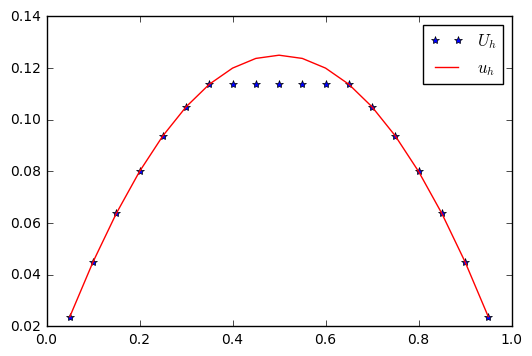

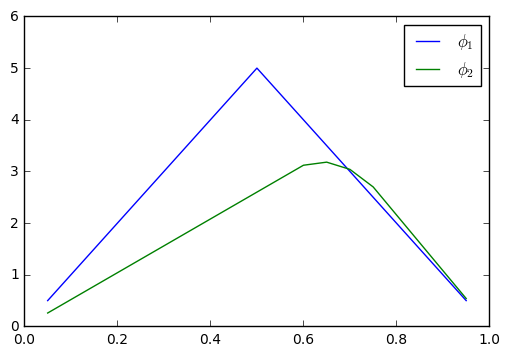

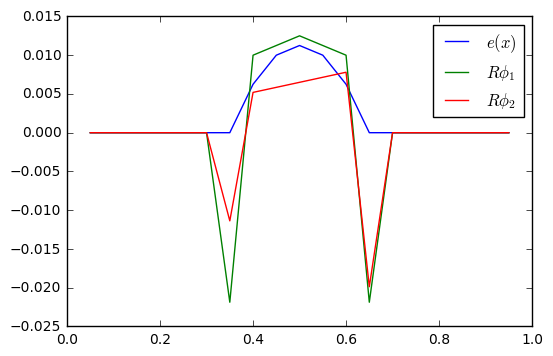

In [11]:
plt.figure(0)
plt.plot(xval, U_h, 'b*', xval, u_h, 'r-')
plt.legend(['$U_h$','$u_h$'])

# Influence functions: Adjoint solutions
plt.figure(1)
plt.plot(xval, phi_1, xval, phi_2)
plt.legend([r'$\phi_1$',r'$\phi_2$'])

# "Local Error Contributions"
plt.figure(2)
plt.plot(xval, u_h-U_h, xval, R*phi_1, xval, R*phi_2)
plt.legend(['$e(x)$', '$R\phi_1$', '$R\phi_2$'])

## A natural extension: Sensitivity analysis

The data above depends upon the choice of $\alpha$. 
In general, $A$ and $b$ may both depend upon some parameters that we collect into a vector we denote $\lambda\in\mathbb{R}^m$.
In other words, the problem is written as
$$
    \large A(\lambda)u_h = b(\lambda), 
$$
and clearly the solution $u_h$ depends upon the parameter (vector) $\lambda$, so we write $u_h(\lambda)$.
Subsequently, $Q(u_h)$ also depends implicitly upon the parameter $\lambda$, and we write $Q(\lambda)$ to make this dependence explicit.
Since parameters are often subject to uncertainty, we are commonly interested in the sensitivity of the QoI with respect to perturbations in these parameters. 

Let $\lambda_i$ denote the $i$th component of the vector $\lambda$ for $1\leq i\leq m$.
Then, differentiating $A(\lambda)u_h = b(\lambda)$ with respect to $\lambda_i$ and following a similar set of steps as used to derive the computable error estimate, we arrive at
$$
 \large	\partial_{\lambda_i} Q(\lambda) = \left< \partial_{\lambda_i} {b}(\lambda) - \left[\partial_{\lambda_i}A(\lambda)\right] {u}(\lambda), {\phi}(\lambda) \right>.
$$
Here, $\phi(\lambda)$ depends upon $\lambda$ since $A^\top$ now also depends upon $\lambda$. 

We can also interpret this as $<\partial_{\lambda_i} R(u), \phi>$, the derivative of the **residual** with respect to the parameter $\lambda_i$. 

However, we only require the partial derivatives of the data and operator $A$ with respect to the parameters in order to determine the partial derivatives of $Q$. 
In other words, we solve ***two problems: the forward and adjoint problem*** and are able to determine the gradient of $Q$ even if $\lambda$ has dimension in the millions. 

What is the alternative?  You solve a linear algebra problem $\partial u/\partial \lambda_i$, one each parameter, of the form
$$
A \frac{\partial u}{\partial \lambda_i} = \frac{\partial R}{\lambda_i} (u)
$$.
Even with a matrix factorization of $A$ this is still unappealing for a large number of parameters and a modest number of QoI.  

Let's look at this example and treat $\alpha$ as the uncertain parameter, noting that $\mathcal{R}_\alpha=\partial{b}{\alpha}=
h^2 \alpha e^{\alpha x_i}$




In [12]:
b_alpha=alpha*b
dQ1dalpha=np.dot(b_alpha,phi_1)
print 'Sensitivity of Q_1 w.r.t. alpha = ',alpha,' is ',dQ1dalpha
dQ2dalpha=np.dot(b_alpha,phi_2)
print 'Sensitivity of Q_2 w.r.t. alpha = ',alpha,' is ',dQ2dalpha

Sensitivity of Q_1 w.r.t. alpha =  0.0  is  0.0
Sensitivity of Q_2 w.r.t. alpha =  0.0  is  0.0


### Adjoint problem as **iterative improvement** for the QoI

We have $Q(U)$ which we can compute directly by $<U,\psi>$.
But we also have $Q(e) \approx <R(U),\Phi>$, so we have $Q(u_h) \approx Q(U) + <R(U),\Phi>$.

In [13]:
print 'Q_1(U)=',U_h[9]
print 'Q_1(u_h)=',u_h[9]
print 'recovered Q_1(U)',U_h[9]+np.dot(R,phi_1)

Q_1(U)= 0.11375
Q_1(u_h)= 0.125
recovered Q_1(U) 0.125
